In [ ]:
# 한국어 폰트를 설치합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 런타임 -> 런타임 다시 시작을 실행해주세요

In [ ]:
!pip install transformers==4.18.0
!pip install datasets==2.11.0

이번 실습에서는 Self Train과 Consistency Regularization과 관련된 방법론을 하나씩 다뤄보겠습니다.

# 0. Data & Preprocessing

이번 실습에서는 이진분류 문제를 다뤄보도록 하겠습니다.
활용할 데이터셋은 개와 음식 사진을 구별하는 데이터셋입니다.
머핀이나 치킨과 비슷하게 생긴 강아지 사진과 실제 머핀 및 치킨 사진을 구별하는 문제입니다.

## 0-1. Data 다운로드 및 예시
온라인 상에 공개되어 있는 데이터를 쉽게 다운받을 수 있도록 도와주는 HuggingFace 사의 Datasets 라이브러리를 이용하여 데이터를 다운로드 받습니다.
(https://huggingface.co/datasets/sasha/dog-food)

In [ ]:
import torch
import torch.utils.checkpoint
from torch import Tensor, nn
from torch.nn import CrossEntropyLoss

from transformers import AutoFeatureExtractor, AutoModel, AutoConfig

from datasets import load_dataset


from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm

import numpy as np
import gc

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 시드 고정
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [ ]:
## 데이터 다운로드 시 1분 이내의 시간이 소요됩니다.
dataset = load_dataset("sasha/dog-food")

## 해당 데이터셋은 Train/Test로 구성되어 있습니다. 이를 우선 분리하겠습니다.
train_dataset = list(dataset["train"])
test_dataset = list(dataset["test"])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/900 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/2100 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/sasha___parquet/sasha--dog-food-ec42a61d5519cc88/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Text(0.5, 1.0, '머핀 이미지')

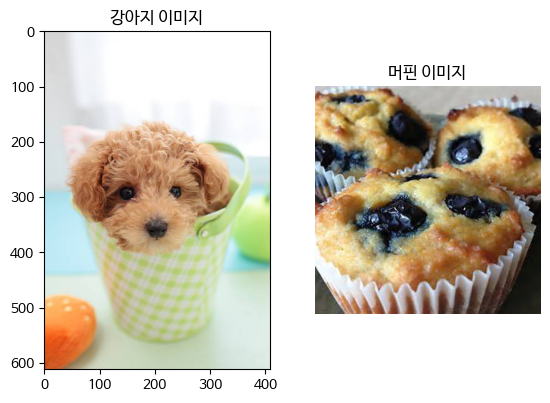

In [ ]:
## 실제 강아지와 음식 사진 예시입니다.
### 강아지 사진은 푸들이 주를 이루고, 음식 사진은 머핀과 치킨이 주를 이루게 됩니다.
plt.subplot(1,2,1)
plt.imshow(train_dataset[3]['image'])
plt.title("강아지 이미지")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_dataset[-2]['image'])
plt.axis('off')
plt.title("머핀 이미지")


우리가 보는 이미지는 모두 행렬 형식으로 구성되어, 컴퓨터에서 처리됩니다.
(높이, 너비, RGB) 형태의 행렬로 구성되어 있습니다.

In [ ]:
dog_arr = np.array(train_dataset[3]['image'])
print(f"강아지 이미지의 행렬 형태 : {dog_arr.shape}")
print(">>> 강아지 이미지의 Red 채널의 픽셀값")
print(dog_arr[:,:,0])

강아지 이미지의 행렬 형태 : (612, 408, 3)
>>> 강아지 이미지의 Red 채널의 픽셀값
[[212 212 212 ... 255 255 255]
 [212 212 212 ... 255 255 255]
 [212 212 212 ... 255 255 255]
 ...
 [187 190 195 ... 221 222 222]
 [192 195 199 ... 221 222 222]
 [195 198 201 ... 221 222 222]]


## 0-2. 모델 및 전처리 파이프라인 다운로드
기본 모델로 사전학습된 ResNet-50(https://arxiv.org/abs/1512.03385)을 사용하겠습니다.
해당 모델은 2015년에 공개된 이미지 분류 모델로서, 현재까지 대부분의 이미지/언어 모델의 기본적인 원리를 구성하고 있습니다.

사전학습된 모델과 모델 입력 전처리를 위한 파이프라인은 HuggingFace 사의 transformers 라이브러리를 이용하여 다운로드하겠습니다.

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
config = AutoConfig.from_pretrained("microsoft/resnet-50", output_hidden_states=True)
model = AutoModel.from_config(config)

Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

In [ ]:
"""
사전학습된 이미지 모델들은 각 모델마다 제각기 다른 전처리 파이프라인을 가지고 있습니다.
이는 사전학습 시 사용된 정보가 다르기 때문에 발생하는 현상입니다.
1. 학습 때 사용된 이미지의 크기
2. 학습 때 사용된 이미지의 채널 수
3. 학습 때 사용된 이미지의 픽셀값 범위
4. 학습 때 사용된 이미지의 Normalization 방법

등 다양한 요소가 영향을 미치게 됩니다. 사전학습된 이미지 모델을 활용할 경우 이러한 요소를 고려하여 전처리를 진행해야 합니다.
"""
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



## 0-3. 전처리 및 모델 출력값 확인

전처리 전 이미지의 크기 : (612, 408, 3)
전처리 후 이미지의 크기 : (224, 224, 3)


Text(0.5, 1.0, 'Preprocessed Image')

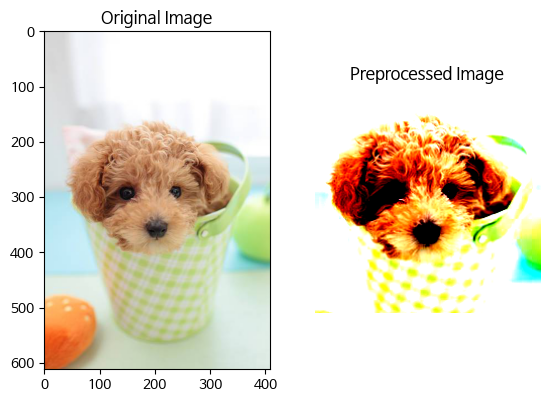

In [ ]:
"""
전처리를 거친 이미지는 다음과 같이 변환됩니다.
"""

original_image = train_dataset[3]['image']
preprocessed_image = feature_extractor(images=original_image)['pixel_values'][0].transpose(1,2,0)
print(f"전처리 전 이미지의 크기 : {np.array(original_image).shape}")
print(f"전처리 후 이미지의 크기 : {preprocessed_image.shape}")

"""
시각화하여 확인해보면 다음과 같습니다.
"""

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(preprocessed_image)
plt.axis('off')
plt.title("Preprocessed Image")


모델 입력 시 1) 이미지의 크기를 일정하도록 이미지 중앙부분을 중심으로 자르고 2) 입력값의 범위를 일정하도록 맞춰주는 작업을 수행하게 됩니다.
그 결과 위와 같이 원본 이미지와 다소 다른 모습을 확인할 수 있습니다.

이제 위와 같은 전처리를 거친 이미지를 모델 입력으로 사용 시 출력을 확인해보겠습니다.

In [ ]:
inputs = feature_extractor(images=original_image, return_tensors="pt") # 모델이 입력으로 받을 수 있는 Pytorch Tensor 형태로 변환합니다.
with torch.no_grad():
    outputs = model(**inputs) # 모델이 입력된 이미지에 대해 벡터 형태의 특징을 추출합니다.

print(f"특징 벡터의 형태 : {outputs.last_hidden_state.shape}")
last_hidden_states = outputs.pooler_output # 모델이 생성한 특징 벡터를 압축하여 2048차원의 벡터로 변환합니다.
print(f"압축된 특징 벡터의 형태 : {last_hidden_states.shape}")

특징 벡터의 형태 : torch.Size([1, 2048, 7, 7])
압축된 특징 벡터의 형태 : torch.Size([1, 2048, 1, 1])


In [ ]:
class ResNetForImageClassification(nn.Module) :
    def __init__(self, feature_extractor, num_labels=2) :
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(self.feature_extractor.config.hidden_sizes[-1], num_labels)
        self.softmax = nn.Softmax(dim=-1)
        self.num_labels = num_labels

        self.id2label = {0 : "강아지", 1 : "음식"}

    def forward(self, pixel_values, labels=None) :
        pixel_values = self.feature_extractor(pixel_values)
        logits = self.classifier(pixel_values.pooler_output.squeeze())
        logits = self.softmax(logits,)

        loss = None
        preds = torch.argmax(logits, dim=-1).reshape(-1, 1)
        if labels is not None :
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))


        return {
            "모델의 예측 확률" : logits,
            "loss" : loss,
            "logits" : logits,
            "모델의 정확도" : (sum(preds == labels.reshape(-1, 1))/len(labels)).item() if labels is not None else None,
            "모델의 예측값" : {'text' : [self.id2label[pred.item()] for pred in preds], 'id' : preds}
            }

>> 입력 이미지의 형태 : torch.Size([1, 3, 224, 224])
>> 모델의 예측 확률 : tensor([0.2374, 0.7626])
>> 모델의 예측 확률의 형태 : torch.Size([2])
>> 모델의 예측 확률의 합 : 1.0
>> 모델의 Loss 값 : 0.4646063446998596
>> 모델의 예측값 : {'text': ['음식'], 'id': tensor([[1]])}
>> 입력 이미지 시각화 : 


(-0.5, 223.5, 223.5, -0.5)

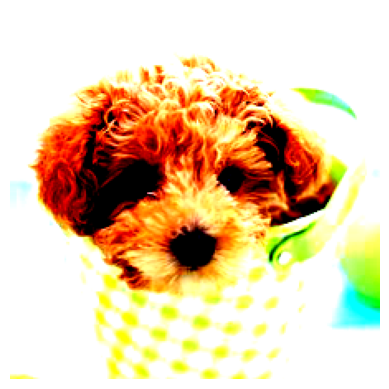

In [ ]:
resnet = ResNetForImageClassification(model, num_labels=2).to('cuda')
with torch.no_grad() :
    inputs['pixel_values'] = inputs['pixel_values'].to('cuda')
    outputs = resnet(inputs['pixel_values'], labels=torch.tensor([[1]]).to('cuda') )

# 시각화를 위해 데이터를 CPU로 이동합니다.
inputs['pixel_values'] = inputs['pixel_values'].to('cpu')
outputs['모델의 예측 확률'] = outputs['모델의 예측 확률'].to('cpu')
outputs['loss'] = outputs['loss'].to('cpu')
outputs['모델의 예측값']['id'] = outputs['모델의 예측값']['id'].to('cpu')

# 결과를 출력합니다.
print(f">> 입력 이미지의 형태 : {inputs['pixel_values'].shape}")
print(f">> 모델의 예측 확률 : {outputs['모델의 예측 확률']}")
print(f">> 모델의 예측 확률의 형태 : {outputs['모델의 예측 확률'].shape}")
print(f">> 모델의 예측 확률의 합 : {torch.sum(outputs['모델의 예측 확률'])}")
print(f">> 모델의 Loss 값 : {outputs['loss']}")
print(f">> 모델의 예측값 : {outputs['모델의 예측값']}")
print(f">> 입력 이미지 시각화 : ")
plt.imshow(inputs['pixel_values'][0].permute(1,2,0))
plt.axis('off')

# 1. Self Tarining
## 1-1. 순차적 진행
첫번째로 다뤄볼 방법론은 Self Training입니다. 해당 알고리즘의 순서는 다음과 같습니다.
0. 소수의 레이블이 존재하는 데이터와, 다수의 레이블이 없는 데이터가 존재한다.
1. 소수의 레이블이 있는 데이터로 모델을 학습한다.
2. 1에서 학습된 모델을 이용하여 다수의 레이블이 없는 데이터에 대한 예측을 수행한다.
3. 예측된 결과물 중 모델이 강한 확신을 가지는 데이터에 대해 레이블을 부여한다.
4. 더 증대된 레이블 데이터로 모델을 처음부터 다시 학습한다.
5. 일정 횟수만큼 1 ~ 4를 반복한다.

위 알고리즘을 하나씩 코드로 수행해보겠습니다.

![](./images/self_train_1.png)

### 1-1-1. 학습 데이터 구축
Self Training은 학습 데이터 구성이 다음과 같습니다.
- 소수의 레이블이 있는 데이터
- 다수의 레이블이 없는 데이터

위 구성에 맞추어 학습 데이터를 구축하겠습니다.

![image.png](./images/self_train_2.png)

In [ ]:
train_labeled_data = []
train_unlabeled_data = []

num_labeled = 8 # 클래스 당 4개씩 레이블이 있는 데이터라고 가정하겠습니다.
num_unlabeled = 512 # 클래스 당 256개씩 레이블이 없는 데이터라고 가정하겠습니다.

num_labeled_0 = 0
num_labeled_1 = 0

num_unlabeled_0 = 0
num_unlabeled_1 = 0

for data_instance in train_dataset :
    img, label = data_instance['image'], data_instance['label']
    if label == 0 and num_labeled_0 < num_labeled//2 : # 강아지 클래스의 데이터를 16개 뽑습니다.
        train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
        num_labeled_0 += 1
    elif label == 1 and num_labeled_1 < num_labeled//2 : # 음식 클래스의 데이터를 16개 뽑습니다.
        train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
        num_labeled_1 += 1
    elif label == 0 and num_unlabeled_0 < num_unlabeled//2 : # 강아지 클래스의 데이터를 256개 뽑습니다.
        train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
        num_unlabeled_0 += 1
    elif label == 1 and num_unlabeled_1 < num_unlabeled//2 : # 음식 클래스의 데이터를 256개 뽑습니다.
        train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
        num_unlabeled_1 += 1

    if (num_labeled_0 == num_labeled//2) and (num_labeled_1 == num_labeled//2) and (num_unlabeled_0 == num_unlabeled//2) and (num_unlabeled_1 == num_unlabeled//2) : # 모든 데이터를 뽑았다면 반복문을 종료합니다.
        break

print("> 학습 데이터셋")
print(f">> 레이블이 있는 데이터셋의 개수 : {len(train_labeled_data)}")
print(f">> 레이블이 없는 데이터셋의 개수 : {len(train_unlabeled_data)}")
print("> 테스트 데이터셋")
print(f">> 테스트 데이터셋의 개수 : {len(test_dataset)}")

> 학습 데이터셋
>> 레이블이 있는 데이터셋의 개수 : 8
>> 레이블이 없는 데이터셋의 개수 : 512
> 테스트 데이터셋
>> 테스트 데이터셋의 개수 : 900


### 1-1-2. 레이블이 있는 데이터를 이용하여 모델 학습

![image.png](./images/self_train_3.png)

In [ ]:
class ImageDataset(torch.utils.data.Dataset) :
    def __init__(self, dataset, feature_extractor) :
        self.dataset = dataset # 학습 데이터셋을 해당 클래스 내부에 저장합니다.
        self.feature_extractor = feature_extractor # 이미지 데이터를 모델 입력으로 변환해주는 feature_extractor를 저장합니다.

    def __len__(self) :
        return len(self.dataset)

    def __getitem__(self, idx) : # 해당 메소드는 인덱스를 입력으로 받아 해당 인덱스에 위치한 데이터를 반환합니다.
        image = self.dataset[idx]['image'] # 해당 인덱스에 위치한 이미지를 불러옵니다.
        label = self.dataset[idx]['label'] # 해당 인덱스에 위치한 레이블을 불러옵니다.

        inputs = self.feature_extractor(images=image, return_tensors="pt") # 모델이 입력으로 받을 수 있는 Pytorch Tensor 형태로 변환합니다.
        inputs['pixel_values'] = inputs['pixel_values'].squeeze() # 해당 이미지의 차원을 (RGB 채널, 이미지 높이, 이미지 너비)로 변경합니다.
        inputs['labels'] = torch.tensor(label) # Loss 계산을 위해 레이블을 추가합니다.
        inputs['idx'] = torch.tensor(idx) # 향후 분석을 위해 인덱스를 추가합니다.

        return inputs

위와 같이 선언된 Dataset 클래스를 이용하여 아래처럼 Batch 단위 연산을 통한 모델 학습이 가능합니다.

In [ ]:
train_labeled_dataset = ImageDataset(train_labeled_data, feature_extractor)
train_dataloader = torch.utils.data.DataLoader(train_labeled_dataset, batch_size=4, shuffle=True)

for batch in train_dataloader :
    print(f">> 배치 데이터의 입력 이미지의 형태 : {batch['pixel_values'].shape}")
    print(f">> 배치 데이터의 레이블의 형태 : {batch['labels'].shape}")
    break

>> 배치 데이터의 입력 이미지의 형태 : torch.Size([4, 3, 224, 224])
>> 배치 데이터의 레이블의 형태 : torch.Size([4])


In [ ]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

log_interval = 1
epoch = 2
iteration = 0
for epoch_idx in range(epoch) :
    for batch in train_dataloader :
        iteration += 1
        batch['pixel_values'] = batch['pixel_values'].to('cuda')
        batch['labels'] = batch['labels'].to('cuda')
        output = resnet(batch['pixel_values'], batch['labels'])
        loss = output['loss']
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if iteration % log_interval == 0 :
            print(f">> 에폭 : {epoch_idx+1 :3} | 반복 : {iteration:3} | Loss : {loss.item():.4f} | 정확도 : {output['모델의 정확도']:.3f}")

del batch, optimizer

>> 에폭 :   1 | 반복 :   1 | Loss : 0.6592 | 정확도 : 0.500
>> 에폭 :   1 | 반복 :   2 | Loss : 0.8100 | 정확도 : 0.500
>> 에폭 :   2 | 반복 :   3 | Loss : 0.6517 | 정확도 : 0.750
>> 에폭 :   2 | 반복 :   4 | Loss : 0.6096 | 정확도 : 0.750


### 1-1-3. 학습된 모델을 이용하여 레이블이 없는 데이터에 대한 예측 수행

![image.png](./images/self_train_4.png)

In [ ]:
threshold = 0.55
train_unlabeled_dataset = ImageDataset(train_unlabeled_data, feature_extractor)
train_unlabeled_dataloader = torch.utils.data.DataLoader(train_unlabeled_dataset, batch_size=16, shuffle=True)

new_labeled_data = []
new_unlabeled_data = []

resnet.eval()
with torch.no_grad() : # 예측만 수행할 때, 계산량을 줄여주는 함수입니다.
    for batch in tqdm(train_unlabeled_dataloader, desc="레이블이 없는 데이터에 대한 예측 중 : ") :
        output = resnet(batch['pixel_values'].to('cuda')) # 예측을 수행하기 위해, 모델의 입력으로 이미지만 사용합니다.
        preds = output['모델의 예측값']['id'].squeeze()
        for i, pred in enumerate(preds) :
            idx = batch['idx'][i].item() # 해당 이미지의 인덱스를 불러옵니다.
            if output['모델의 예측 확률'][i][pred] > threshold :
                new_labeled_data.append(train_unlabeled_data[idx]) # 예측 확률이 0.7 이상이라면, 레이블이 있는 데이터셋에 추가합니다.
            else :
                new_unlabeled_data.append(train_unlabeled_data[idx]) # 예측 확률이 0.7 미만이라면, 레이블이 없는 데이터셋에 추가합니다.

resnet.train()
print(f">> 레이블이 있는 데이터셋의 개수 : {len(new_labeled_data)}")
print(f">> 레이블이 없는 데이터셋의 개수 : {len(new_unlabeled_data)}")

del resnet, batch
gc.collect()

레이블이 없는 데이터에 대한 예측 중 :   0%|          | 0/32 [00:00<?, ?it/s]

>> 레이블이 있는 데이터셋의 개수 : 512
>> 레이블이 없는 데이터셋의 개수 : 0


2811

In [ ]:
print(f">> 레이블이 있는 데이터셋의 개수 : {len(new_labeled_data)}")
print(f">> 레이블이 없는 데이터셋의 개수 : {len(new_unlabeled_data)}")

>> 레이블이 있는 데이터셋의 개수 : 512
>> 레이블이 없는 데이터셋의 개수 : 0


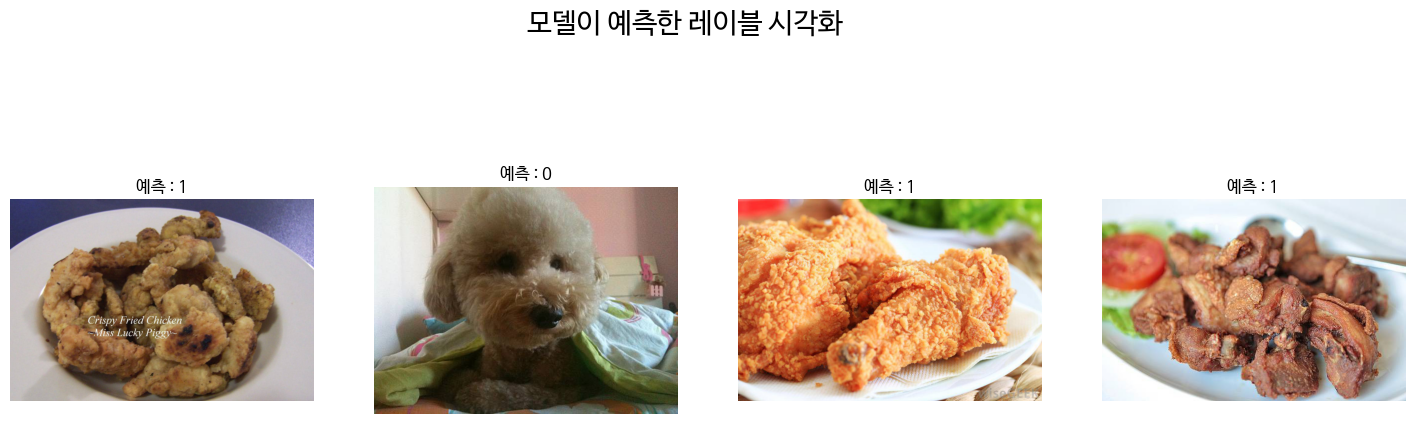

In [ ]:
plt.figure(figsize=(18, 6))
plt.suptitle("모델이 예측한 레이블 시각화", fontsize=20)
max_len = min(len(new_labeled_data), 4)
rand = np.random.randint(0, len(new_labeled_data), max_len)
vis_data = [new_labeled_data[idx] for idx in rand]
if max_len != 0 :
    for idx, data in enumerate(vis_data) :
        plt.subplot(1, 4, idx+1)
        plt.imshow(data['image'])
        plt.axis('off')
        plt.title(f"예측 : {data['label']}")
    plt.show()


In [ ]:
print(f">> (기존) 레이블이 있는 데이터셋의 개수 : {len(train_labeled_data)}")
print(f">> (기존) 레이블이 없는 데이터셋의 개수 : {len(train_unlabeled_data)}")
print(f">> (변경) 새로 레이블이 추가된 데이터셋의 개수 : {len(new_labeled_data)}")
print(f">> (변경) 레이블이 없는 데이터셋의 개수 : {len(new_unlabeled_data)}")

train_labeled_data += new_labeled_data # 레이블이 있는 데이터셋에 새로 예측된 데이터를 추가합니다.
train_unlabeled_data = new_unlabeled_data # 기존의 레이블이 없는 데이터셋을 새롭게 정의합니다.

print(f">> (변경) 레이블이 있는 데이터셋의 개수 : {len(train_labeled_data)}")
print(f">> (변경) 레이블이 없는 데이터셋의 개수 : {len(train_unlabeled_data)}")

>> (기존) 레이블이 있는 데이터셋의 개수 : 8
>> (기존) 레이블이 없는 데이터셋의 개수 : 512
>> (변경) 새로 레이블이 추가된 데이터셋의 개수 : 512
>> (변경) 레이블이 없는 데이터셋의 개수 : 0
>> (변경) 레이블이 있는 데이터셋의 개수 : 520
>> (변경) 레이블이 없는 데이터셋의 개수 : 0


위와 같은 과정을 반복하면서 모델이 학습하는 데이터셋의 크기는 점차 늘어나게 됩니다. 위와 같은 과정을 지속해서 반복하면서 모델이 test 데이터에 대한 성능이 어떻게 변화하는지 살펴보도록 하겠습니다.

## 1-2. 학습 과정 함수화
위 과정을 함수로 구성하여 전체 과정을 반복적으로 진행할 수 있도록 하겠습니다.

In [ ]:
def get_model() :
    feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
    config = AutoConfig.from_pretrained("microsoft/resnet-50")
    model = AutoModel.from_config(config)
    resnet = ResNetForImageClassification(model, num_labels=2).to('cuda')
    return resnet, feature_extractor

def get_data(num_labeled = 32, num_unlabeled = 512) :
    dataset = load_dataset("sasha/dog-food")

    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    train_labeled_data = []
    train_unlabeled_data = []

    num_labeled_0 = 0
    num_labeled_1 = 0

    num_unlabeled_0 = 0
    num_unlabeled_1 = 0

    for img, label in zip(train_dataset['image'], train_dataset['label']) :
        if label == 0 and num_labeled_0 < num_labeled//2 : # 강아지 클래스의 데이터를 16개 뽑습니다.
            train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
            num_labeled_0 += 1
        elif label == 1 and num_labeled_1 < num_labeled//2 : # 음식 클래스의 데이터를 16개 뽑습니다.
            train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
            num_labeled_1 += 1
        elif label == 0 and num_unlabeled_0 < num_unlabeled//2 : # 강아지 클래스의 데이터를 256개 뽑습니다.
            train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
            num_unlabeled_0 += 1
        elif label == 1 and num_unlabeled_1 < num_unlabeled//2 : # 음식 클래스의 데이터를 256개 뽑습니다.
            train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
            num_unlabeled_1 += 1

        if (num_labeled_0 == num_labeled//2) and (num_labeled_1 == num_labeled//2) and (num_unlabeled_0 == num_unlabeled//2) and (num_unlabeled_1 == num_unlabeled//2) : # 모든 데이터를 뽑았다면 반복문을 종료합니다.
            break

    return train_labeled_data, train_unlabeled_data, test_dataset

def train(model, optimizer, train_labeled_dataloader, num_epoch = 5, log_interval = 1) :
    model.train()
    iteration = 0
    for epoch_idx in range(num_epoch+1) :
        for batch in train_labeled_dataloader :
            batch['pixel_values'] = batch['pixel_values'].to('cuda')
            batch['labels'] = batch['labels'].to('cuda')
            iteration += 1
            output = model(batch['pixel_values'], batch['labels'])
            loss = output['loss']
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if iteration % log_interval == 0 :
                print(f">> 에폭 : {epoch_idx+1 :2} | 반복 : {iteration:4} | Loss : {loss.item():.4f} | 정확도 : {output['모델의 정확도']:.3f}")

def update_labeled_data(model, unlabeled_dataloader, labeled_data, unlabeled_data, threshold = 0.9) :
    model.eval()
    new_labeled_data = []
    new_unlabeled_data = []

    original_label = []
    missed_label = []
    with torch.no_grad() : # 예측만 수행할 때, 계산량을 줄여주는 함수입니다.
        for batch in tqdm(unlabeled_dataloader, desc="레이블이 없는 데이터에 대한 예측 중 : ") :
            batch['pixel_values'] = batch['pixel_values'].to('cuda')
            batch['labels'] = batch['labels'].to('cuda')
            output = model(batch['pixel_values']) # 예측을 수행하기 위해, 모델의 입력으로 이미지만 사용합니다.
            preds = output['모델의 예측값']['id'].reshape(-1)
            for i, pred in enumerate(preds) :
                idx = batch['idx'][i].item()

                if output['모델의 예측 확률'][i][pred] > threshold :
                    new_labeled_data.append({'image' : unlabeled_data[idx]['image'], 'label' : pred.item()})
                    original_label.append(batch['labels'][i].item())
                else :
                    new_unlabeled_data.append({'image' : unlabeled_data[idx]['image'], 'label' : unlabeled_data[idx]['label']})
                    missed_label.append(batch['labels'][i].item())

    print(f"========== 예측된 이미지 시각화 ==========")
    plot_pred(new_labeled_data, original_label, "새로 레이블이 추가된 데이터")
    print(f"=======================================")
    plot_pred(new_unlabeled_data, missed_label, "레이블이 추가되지 못한 데이터")
    print(f"=======================================")

    model.train()

    labeled_data+= new_labeled_data # 레이블이 있는 데이터셋에 새로 예측된 데이터를 추가합니다.

    return labeled_data, new_unlabeled_data

def test(model, test_dataloader) :
    model.eval()
    pred_list = []
    label_list = []
    with torch.no_grad() :
        for batch in tqdm(test_dataloader, desc="테스트 데이터에 대한 예측 중 : ") :
            batch['pixel_values'] = batch['pixel_values'].to('cuda')
            batch['labels'] = batch['labels'].to('cuda')
            output = model(batch['pixel_values'], batch['labels'])
            pred_list += output['모델의 예측값']['id'].squeeze().tolist()
            label_list += batch['labels'].squeeze().tolist()

    return pred_list, label_list

def get_dataloader(dataset, feature_extractor, batch_size = 4, shuffle = True) :
    dataset = ImageDataset(dataset, feature_extractor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def plot_pred(new_labeled_data, original_label = None, title = None) :
    """
    입력된 데이터 중 랜덤한 4개의 예측 결과를 시각화하는 함수입니다.
    """

    plt.figure(figsize=(18, 6))
    plt.suptitle(title, fontsize=20)
    max_len = min(len(new_labeled_data), 4)
    rand = np.random.choice(len(new_labeled_data), max_len, replace = False)
    vis_data = [new_labeled_data[idx] for idx in rand]
    if original_label is not None:
      vis_label = [original_label[idx] for idx in rand]
    if max_len != 0 :
        for idx, data in enumerate(vis_data) :
            plt.subplot(1, 4, idx+1)
            plt.imshow(data['image'])
            plt.axis('off')
            plt.title(f"예측 : {data['label']} | 실제 레이블 : {vis_label[idx] if original_label is not None else data['label']}")
        plt.show()

In [ ]:
def self_train(num_train_epoch, num_labeled, num_unlabeled, num_repeat = 3, threshold = 0.9, log_interval = 1, batch_size = 16) :
    train_labeled_data, train_unlabeled_data, test_dataset = get_data(num_labeled, num_unlabeled)
    resnet, feature_extractor = get_model()
    train_labeled_dataloader = get_dataloader(train_labeled_data, feature_extractor, shuffle = True, batch_size=batch_size)
    train_unlabeled_dataloader = get_dataloader(train_unlabeled_data, feature_extractor, shuffle=False, batch_size=batch_size)
    test_dataset = get_dataloader(test_dataset, feature_extractor, shuffle=False)

    acc_list = [0]
    f1_list = [0]
    labeled_num = [len(train_labeled_data)]
    unlabeled_num = [len(train_unlabeled_data)]

    for repeat_idx in range(num_repeat) :
        del resnet, feature_extractor # 매 반복마다 모델을 새롭게 정의합니다.
        gc.collect()
        resnet, feature_extractor = get_model() # 매 반복마다 모델을 새롭게 정의합니다.
        optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4) # 매 반복마다 옵티마이저를 새롭게 정의합니다.
        print("-"*50)
        print(f">>>>>>>>>>>>>>> {repeat_idx+1}번째 반복 시작 <<<<<<<<<<<<<<<<")
        print(f">>> 학습 시작")
        train(resnet, optimizer, train_labeled_dataloader, num_epoch = num_train_epoch, log_interval = log_interval)
        print(f">>> 학습 종료 및 레이블이 없는 데이터에 대한 예측 시작")
        before_labeled_num = len(train_labeled_data)
        before_unlabeled_num = len(train_unlabeled_data)
        train_labeled_data, train_unlabeled_data = update_labeled_data(resnet, train_unlabeled_dataloader, train_labeled_data, train_unlabeled_data, threshold = threshold)
        train_labeled_dataloader = get_dataloader(train_labeled_data, feature_extractor, shuffle = True, batch_size=batch_size)
        train_unlabeled_dataloader = get_dataloader(train_unlabeled_data, feature_extractor, shuffle=False, batch_size=batch_size)

        print(f">>> 학습 데이터셋의 크기 : {before_labeled_num} -> {len(train_labeled_data)}")
        print(f">>> 레이블이 없는 데이터셋의 크기 : {before_unlabeled_num} -> {len(train_unlabeled_data)}")
        labeled_num.append(len(train_labeled_data))
        unlabeled_num.append(len(train_unlabeled_data))


        print(f">>> 테스트 시작")
        pred_list, label_list = test(resnet, test_dataset)
        print(f">>> 테스트 종료")
        acc = accuracy_score(label_list, pred_list)
        f1 = f1_score(label_list, pred_list)
        acc_list = acc_list + [acc]
        f1_list = f1_list + [f1]

        print(f">>> 정확도 : {acc:.3f}")
        print(f">>> F1 Score : {f1:.3f}")
        print("-"*50)

        if len(train_unlabeled_data) == 0 :
            print(">>>>>>>> 레이블이 없는 데이터가 모두 레이블링 되었습니다.") # 레이블이 없는 데이터가 모두 레이블링 되었다면 반복문을 종료합니다.
            break

    return model, acc_list, f1_list, labeled_num, unlabeled_num

## 1-3. 실험 진행

### 1-3-1. 기본 실험

In [ ]:
## 아래 조건의 코드에선 학습된 모델에서 threshold를 넘는 확률을 예측하지 못해, 레이블이 있는 데이터가 추가되지 못합니다.
model, acc_list, f1_list, labeled_num, unlabeled_num = self_train(num_train_epoch = 1, num_labeled = 4, num_unlabeled = 128, num_repeat = 1, threshold = 0.9, log_interval = 1, batch_size=4)

## 이를 완화하기 위해서는 두가지 방법이 있습니다. 1) 레이블 데이터를 늘리기 2) 학습 epoch 수를 늘리기 3) threhold를 높이기


  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


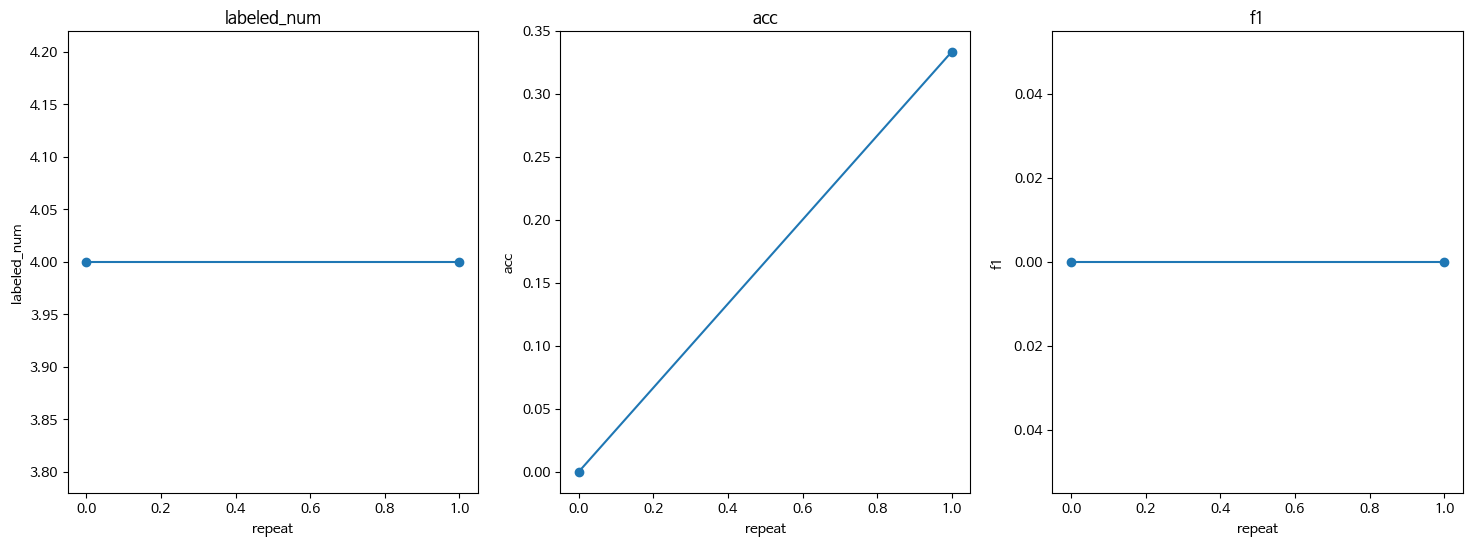

In [ ]:
## Self Train 반복에 따른 레이블링된 데이터 수 및 정확도, F1 Score 변화를 line plot으로 시각화합니다.
def visualize_result(acc_list, f1_list, labeled_num) :

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(labeled_num, label="labeled_num", marker = 'o')
    plt.xlabel("repeat")
    plt.ylabel("labeled_num")
    plt.title("labeled_num")


    plt.subplot(1, 3, 2)
    plt.plot(acc_list, label="acc", marker = 'o')
    plt.xlabel("repeat")
    plt.ylabel("acc")
    plt.title("acc")

    plt.subplot(1, 3, 3)
    plt.plot(f1_list, label="f1", marker = 'o')
    plt.xlabel("repeat")
    plt.ylabel("f1")
    plt.title("f1")

    plt.show()

visualize_result(acc_list, f1_list, labeled_num)

### 1-3-2. Epoch 및 Threshold에 따른 변화

In [ ]:
### 1. 레이블 데이터 수를 늘리는 경우
model, acc_list, f1_list, labeled_num, unlabeled_num = self_train(num_train_epoch = 1, num_labeled = 128, num_unlabeled = 128, num_repeat = 3, threshold = 0.9, log_interval = 1, batch_size=4)
visualize_result(acc_list, f1_list, labeled_num)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
### 2. threshold를 높이는 경우
model, acc_list, f1_list, labeled_num, unlabeled_num = self_train(num_train_epoch = 1, num_labeled = 128, num_unlabeled = 128, num_repeat = 3, threshold = 0.99, log_interval = 10, batch_size=4)
visualize_result(acc_list, f1_list, labeled_num)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
### 3. 레이블이 없는 데이터가 늘어날 경우
model, acc_list, f1_list, labeled_num, unlabeled_num = self_train(num_train_epoch = 1, num_labeled = 128, num_unlabeled = 1024, num_repeat = 5, threshold = 0.99, log_interval = 20, batch_size=4)
visualize_result(acc_list, f1_list, labeled_num)

Output hidden; open in https://colab.research.google.com to view.